### **Install and import packages**

In [265]:
import tarfile
import timeit
import random
import math
import re
import itertools
import datetime 

from operator import itemgetter
from scipy.signal import cheby2, resample, sosfilt
from scipy import signal
from scipy.io import loadmat, savemat
from tensorly import tensor as tensor_tly
from tensorly import norm, dot
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2, l1_l2

import numpy as np
import pandas as pd
import ecg_plot
import seaborn as sns
import matplotlib.pyplot as plt
import logging
%matplotlib inline

In [2]:
class Database(object):
  def __init__(self, path, leads):
    self.path = path
    self.leads = leads
    self.freq = 0
    self.headers_path = []
    self.recordings_path = []
    

  def extract_from_drive(self):
    if not os.path.exists(self.path):
      with tarfile.open(self.path) as zip_file:
        zip_file.extractall()
    

  def load_hea_file(self, i):
    with open(self.headers_path[i], 'r') as f:
      hea_file = f.read()
    return hea_file


  def get_frequency(self):
    header = self.load_hea_file(0)
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                self.freq = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    print(f'Frequency: {self.freq}')


  def __str__(self):
    return f'Database(folder={self.folder}, path_drive={self.path_drive}, freq={self.freq},  leads={self.leads}, headers_paths={len(self.headers_paths)}, recordings_paths={len(self.recordings_paths)})'


  def load_paths(self):
    for f in sorted(os.listdir(self.path)):
      root, extension = os.path.splitext(f)
      if not root.startswith('.') and extension=='.hea':
        header_db_file = os.path.join(self.path, root + '.hea')
        recording_db_file = os.path.join(self.path, root + '.mat')
        if os.path.isfile(header_db_file) and os.path.isfile(recording_db_file):
          self.headers_path.append(header_db_file)
          self.recordings_path.append(recording_db_file)
    print(f'Found {len(self.headers_path)} recordings in {self.path}.')

In [3]:
class Diagnostic(object):
  diagnostics = []


  @classmethod
  def append_diagnostic(cls, diagnostic):
    cls.diagnostics.append(diagnostic)


  @classmethod
  def get_diagnostics(cls):
    return cls.diagnostics


  def __init__(self, diag_name, abbrev, code):
    self.name = diag_name
    self.abbrev = abbrev
    self.code = code

In [235]:
class DiagnosticDatabase(object):
  databases = []

  @classmethod
  def append_database(cls, diag_db):
    cls.databases.append(diag_db)   

    
  @classmethod
  def get_df_recordings(cls):  
    total_recs = []
    for diag_db in cls.databases:
        recs = [rec.__dict__ for rec in diag_db.recordings_diag]
        recs = [dict(rec, diagnostic=diag_db.diagnostic.code) for rec in recs]
        total_recs.append(recs)
    total_recs = [rec for db in total_recs for rec in db]
    dataframe = pd.DataFrame(total_recs)
    return dataframe
    

  def __init__(self, diag_origin, db_origin):
    self.diagnostic = diag_origin
    self.db = db_origin
    self.headers_diag_path = []
    self.recordings_diag = []
    #self.logger = logger


  def get_labels(self, header):
    labels = list()
    for l in header.split('\n'):
      if l.startswith('#Dx'):
        try:
          entries = l.split(': ')[1].split(',')
          for entry in entries:
            labels.append(entry.strip())
        except:
          pass
    return labels


  def get_leads(self,header):
    leads = list()
    for i, l in enumerate(header.split('\n')):
      entries = l.split(' ')
      if i==0:
        num_leads = int(entries[1])
      elif i<=num_leads:
        leads.append(entries[-1])
      else:
        break
    return tuple(leads)


  def choose_leads(self, recording, header, leads):
    num_leads = len(leads)
    num_samples = np.shape(recording)[1]
    chosen_recording = np.zeros((num_leads, num_samples), recording.dtype)
    available_leads = self.get_leads(header)
    for i, lead in enumerate(leads):
      if lead in available_leads:
        j = available_leads.index(lead)
        chosen_recording[i, :] = recording[j, :]
    return chosen_recording

  def plot_ecg(self, index):
    ecg_plot.plot(self.rsp_cut_recordings_diag[index]/1000, sample_rate=self.db.freq/2, title='')
    ecg_plot.show()

In [236]:
class Record():
  def __init__(self, path, diagnostic, inf, sup, data):
    self.path = path
    self.diagnostic = diagnostic
    self.inf = inf
    self.sup = sup
    self.data = data

### **Load Data**

In [237]:
DiagnosticDatabase.databases = []
Diagnostic.diagnostics = []

# Define diagnosis
af_diag = Diagnostic('Atrial Fibrilation', 'AF', '164889003')
sr_diag = Diagnostic('Sinus Rhythm', 'SR', '426783006')
Diagnostic.append_diagnostic(af_diag)
Diagnostic.append_diagnostic(sr_diag)

path_folder = 'PhysioNet-CinC21/'
available_databases = os.listdir(path_folder)
try:
    available_databases.remove('WFDB_PTB.tar.gz')
    available_databases.remove('WFDB_StPetersburg.tar.gz')
except ValueError:
    pass
available_databases = list(map(lambda db: path_folder + db, available_databases))
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

# Databases
for path in available_databases[0:1]:
  folder = re.search('PhysioNet-CinC21/(.*)', path).group(1)
  db = Database(path, leads)
  db.load_paths()
  db.get_frequency()
    
  # Diagnostics
  for diag in Diagnostic.get_diagnostics():
    diag_db = DiagnosticDatabase(diag, db)
    
    # Recordings
    for i, header_path in enumerate(diag_db.db.headers_path):
      header = diag_db.db.load_hea_file(i)
      labels = diag_db.get_labels(header)
      if diag_db.diagnostic.code in labels:
        # Get record
        rec_file = header_path.replace('hea', 'mat')
        recording = loadmat(rec_file)['val']
        recording = diag_db.choose_leads(recording, header, diag_db.db.leads)
        recording = np.array(recording, dtype=np.float64)
        
        # Filtering
        sos = signal.cheby2(12, 20, [0.35, 70], 
                            'bandpass', 
                            fs= diag_db.db.freq, 
                            output='sos')
        for lead in range(0, recording.shape[0]):
            to_filt = np.array(recording[lead, :], dtype=np.float64)
            filtered = signal.sosfilt(sos, to_filt)
            recording[lead, :] = np.array(filtered, dtype=np.float64)

        # Resample record to 250Hz
        new_freq = 250
        time_rec = len(recording[0])/diag_db.db.freq
        n_samples = int(time_rec*new_freq)
        recording = resample(recording, n_samples, axis=1)

        # Cut record in 250 samples
        interval = 250
        size_rec = recording.shape[1]
        samples_rec = math.floor(size_rec/interval)
        for i in range(0, samples_rec):
          inf = i*interval
          sup = ((i+1)*interval)
          recording_interval = np.array(list(map(lambda lead: lead[inf:sup], recording)))
          record = Record(header_path, 
                          diag_db.diagnostic.abbrev, 
                          inf, 
                          sup, 
                          recording_interval)
          diag_db.recordings_diag.append(record)

        diag_db.headers_diag_path.append(header_path)
    print(f' - Found {len(diag_db.headers_diag_path)} recordings for {diag_db.diagnostic.abbrev}.')
    print(f' - Unattached {len(diag_db.recordings_diag)} intervals.')
    DiagnosticDatabase.append_database(diag_db)

Found 6877 recordings in PhysioNet-CinC21/WFDB_CPSC2018.
Frequency: 500.0
 - Found 1221 recordings for AF.
 - Unattached 18306 intervals.
 - Found 918 recordings for SR.
 - Unattached 14116 intervals.


,path,diagnostic,inf,sup,data
0,PhysioNet-CinC21/WFDB_CPSC2018/A0003.hea,164889003,0,250,"[[-23.885038156081563, 17.70583228179191, -5.3..."
1,PhysioNet-CinC21/WFDB_CPSC2018/A0003.hea,164889003,250,500,"[[51.73439011341387, 87.93573093015405, 130.49..."
2,PhysioNet-CinC21/WFDB_CPSC2018/A0003.hea,164889003,500,750,"[[22.923256386617584, 23.475818538100857, 0.24..."
3,PhysioNet-CinC21/WFDB_CPSC2018/A0003.hea,164889003,750,1000,"[[86.20141066483765, 113.25907030755248, 42.41..."
4,PhysioNet-CinC21/WFDB_CPSC2018/A0003.hea,164889003,1000,1250,"[[131.45677361020878, 105.94695006418243, 88.8..."
...,...,...,...,...,...
32417,PhysioNet-CinC21/WFDB_CPSC2018/A6870.hea,426783006,1250,1500,"[[33.884093080772395, 41.565911540729495, 44.1..."
32418,PhysioNet-CinC21/WFDB_CPSC2018/A6870.hea,426783006,1500,1750,"[[-58.75891303176761, -62.386588961866316, -56..."
32419,PhysioNet-CinC21/WFDB_CPSC2018/A6870.hea,426783006,1750,2000,"[[126.80722011800071, 125.07643139225269, 116...."
32420,PhysioNet-CinC21/WFDB_CPSC2018/A6870.hea,426783006,2000,2250,"[[-31.922285113006435, -25.09245482004895, -25..."


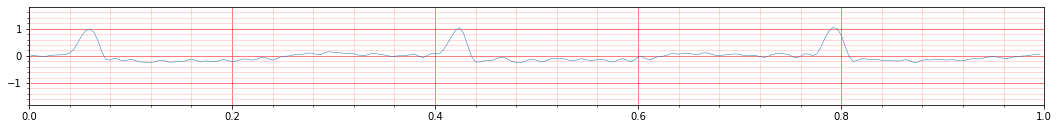

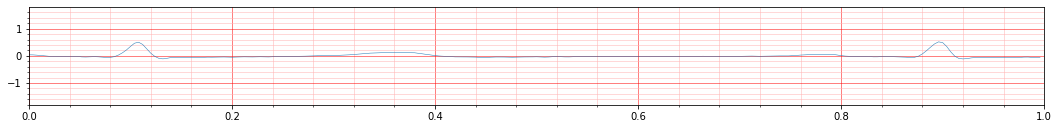

In [284]:
df = DiagnosticDatabase.get_df_recordings()
ecg_plot.plot_1(df.iloc[0].data[0, :]/1000, sample_rate=250, title='')
ecg_plot.plot_1(df.iloc[-1].data[0, :]/1000, sample_rate=250, title='')
df

In [282]:
filename = str(datetime.datetime.now())
filename = filename.replace(' ', '_').replace(':', '_').replace('.', '_')
filename = '_'.join(filename.split('_')[:-1])
df.to_csv(f'{filename}.csv', index=False)  